In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../')
from models.lvae import LadderVAE
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from boilerplate import boilerplate
import lib.utils as utils
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Found 21 files.
(21, 1200, 1200)
(21, 1200, 1200)


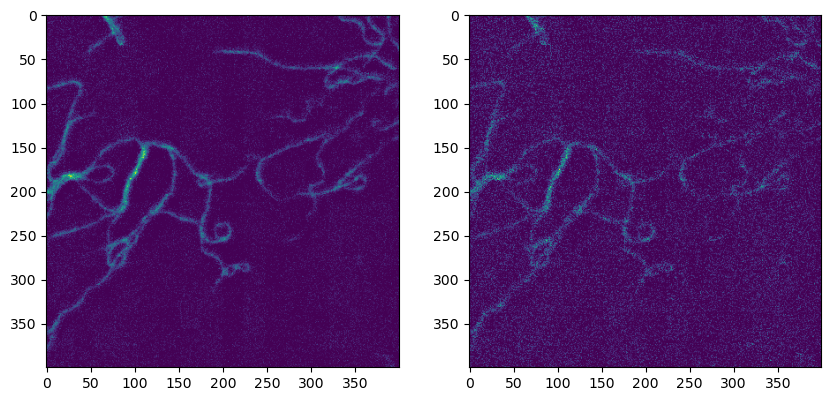

In [4]:
data_path_signal = Path(r"E:\dl_monalisa\n2v_results\Vimentin\Vim_fixed_OnGtAvg_mse")
data_path_obs = Path(r"E:\dl_monalisa\n2v_results\Vimentin\Vim_fixed_OnInpSingle_mse")
signal = []
observation = []

filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)

#print(files)
assert len(files_obs) == len(files_signal)
print(f"Found {len(files_signal)} files.")
for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]

    if file_signal.split('.')[-1] not in filters:
        print(f"skipping {file_signal} because not in filters")
        continue
    
    im_signal = imread(data_path_signal / file_signal)[0]
    im_obs  = imread(data_path_obs / file_obs)[0]

    observation.append(im_obs)
    sig = im_signal
    sig[sig<0] = 0
    signal.append(sig)

signal = np.stack(signal)
observation = np.stack(observation)

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(signal[0][400:800,400:800])

plt.subplot(1,2,2)
plt.imshow(observation[0][400:800,400:800])

print(signal.shape)
print(observation.shape)

In [5]:
train_data = observation[:int(0.85*observation.shape[0])]
val_data= observation[int(0.85*observation.shape[0]):]
print("Shape of training images:", train_data.shape, "Shape of validation images:", val_data.shape)
train_data = utils.augment_data(train_data) ### Data augmentation disabled for fast training, but can be enabled

Shape of training images: (17, 1200, 1200) Shape of validation images: (4, 1200, 1200)
Raw image size after augmentation (136, 1200, 1200)


In [6]:
train_data_gt = signal[:int(0.85*signal.shape[0])]
val_data_gt= signal[int(0.85*signal.shape[0]):]
print("Shape of training images:", train_data.shape, "Shape of validation images:", val_data.shape)
train_data_gt = utils.augment_data(train_data_gt) ### Data augmentation disabled for fast training, but can be enabled

Shape of training images: (136, 1200, 1200) Shape of validation images: (4, 1200, 1200)
Raw image size after augmentation (136, 1200, 1200)


In [7]:
patch_size = 64

img_width = observation.shape[2]
img_height = observation.shape[1]
num_patches = int(float(img_width*img_height)/float(patch_size**2)*1)

### choose correct lines depending on if gt or not ###

# train_images = utils.extract_patches(train_data, patch_size, num_patches)
# val_images = utils.extract_patches(val_data, patch_size, num_patches)

train_images,train_images_gt = utils.extract_patches_supervised(train_data,train_data_gt, patch_size, num_patches)
val_images,val_images_gt  = utils.extract_patches_supervised(val_data,val_data_gt, patch_size, num_patches)


val_images = val_images[:1000] # We limit validation patches to 1000 to speed up training but it is not necessary
val_images_gt = val_images_gt [:1000] 
test_images = val_images[:100]
test_images_gt = val_images_gt[:100]
img_shape = (train_images.shape[1], train_images.shape[2])
print("Shape of training images:", train_images.shape, "Shape of validation images:", val_images.shape)

100%|██████████| 4/4 [00:00<00:00, 94.21it/s]

Shape of training images: (47736, 64, 64) Shape of validation images: (1000, 64, 64)


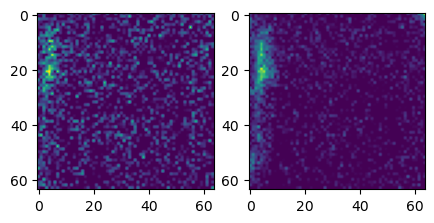

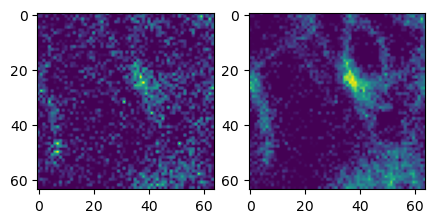

In [8]:
import random
idx = random.randrange(train_images.shape[0])

plt.figure(figsize=(5,10))
plt.subplot(1,2,1)
plt.imshow(train_images[idx])

plt.subplot(1,2,2)
plt.imshow(train_images_gt[idx])

idx = random.randrange(val_images.shape[0])
plt.figure(figsize=(5,10))
plt.subplot(1,2,1)
plt.imshow(val_images[idx])

plt.subplot(1,2,2)
plt.imshow(val_images_gt[idx])

# Configure Hierarchical DivNoising model

<code>model_name</code> specifies the name of the model with which the weights will be saved and wil be loaded later for prediction.<br>
<code>directory_path</code> specifies the directory where the model weights and the intermediate denoising and generation results will be saved. <br>
<code>gaussian_noise_std</code> is only applicable if dataset is synthetically corrupted with Gaussian noise of known std. For real datasets, it should be set to ```None```.<br>
<code>noiseModel</code> specifies a noise model for training. If noisy data is generated synthetically using Gaussian noise, set it to None. Else set it to the GMM based noise model (.npz file)  generated from '1-CreateNoiseModel.ipynb'.<br>
<code>batch_size</code> specifies the batch size used for training. The default batch size of $64$ works well for most microscopy datasets.<br>
<code>virtual_batch</code> specifies the virtual batch size used for training. It divides the <code>batch_size</code> into smaller mini-batches of size <code>virtual_batch</code>. Decrease this if batches do not fit in memory.<br>
<code>test_batch_size</code> specifies the batch size used for testing every $1000$ training steps. Decrease this if test batches do not fit in memory, it does not have any consequence on training. It is just for intermediate visual debugging.<br>
<code>lr</code> specifies the learning rate.<br>
<code>max_epochs</code> specifies the total number of training epochs. Around $150-200$ epochs work well generally.<br>
<code>steps_per_epoch</code> specifies how many steps to take per epoch of training. Around $400-500$ steps work well for most datasets.<br>
<code>num_latents</code> specifies the number of stochastic layers. The default setting of $6$ works well for most datasets but quite good results can also be obtained with as less as $4$ layers. However, more stochastic layers may improve performance for some datasets at the cost of increased training time.<br>
<code>z_dims</code> specifies the number of bottleneck dimensions (latent space dimensions) at each stochastic layer per pixel. The default setting of $32$ works well for most datasets.<br>
<code>blocks_per_layer</code> specifies how many residual blocks to use per stochastic layer. Usually, setting it to be $4$ or more works well. However, more residual blocks improve performance at the cost of increased training time.<br>
<code>batchnorm</code> specifies if batch normalization is used or not. Turning it to True is recommended.<br>
<code>free_bits</code> specifies the threshold below which KL loss is not optimized for. This prevents the [KL-collapse problem](https://arxiv.org/pdf/1511.06349.pdf%3Futm_campaign%3DRevue%2520newsletter%26utm_medium%3DNewsletter%26utm_source%3Drevue). The default setting of $1.0$ works well for most datasets.<br>

**__Note:__** With these settings, training will take approximately $24$ hours on Tesla P100/Titan Xp GPU needing about 6 GB GPU memory. We optimized the code to run on less GPU memory. For faster training, consider increasing ```virtual_batch_size``` but since we have not tested with different settings of ```virtual_batch_size```, we do not yet know how this affects results. To reduce traing time, also consider reducing either ```num_latents``` or ```blocks_per_layer``` to $4$. These settings will bring down the training time to around $12-15$ hours while still giving good results.

In [9]:
model_name = "Vim_RepeatSupervisedSingleToAvg_NormHist_withAugment"
directory_path = "./Trained_model/" 

# Data-specific
gaussian_noise_std = None
noise_model_params= np.load(r"E:\dl_monalisa\n2v_results\Vimentin\noise_models\GMM_Single_AvgGT_normalized.npz")
noiseModel = GaussianMixtureNoiseModel(params = noise_model_params, device = device)

# Training-specific
batch_size=64
virtual_batch = 8
lr=3e-4
max_epochs = 500
steps_per_epoch=400
test_batch_size=100

# Model-specific
num_latents = 4
z_dims = [32]*int(num_latents)
blocks_per_layer = 4
batchnorm = True
free_bits = 1.0

In [10]:
# Choose make_data_manager for supervised training or make_data_manager 2 for supervised

# train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager(train_images,val_images,
#                                                                                            test_images,batch_size,
#                                                                                            test_batch_size)

train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager_supervised(train_images,train_images_gt,val_images,
                                                                                           val_images_gt, test_images,test_images_gt,
                                                                                           batch_size,test_batch_size)

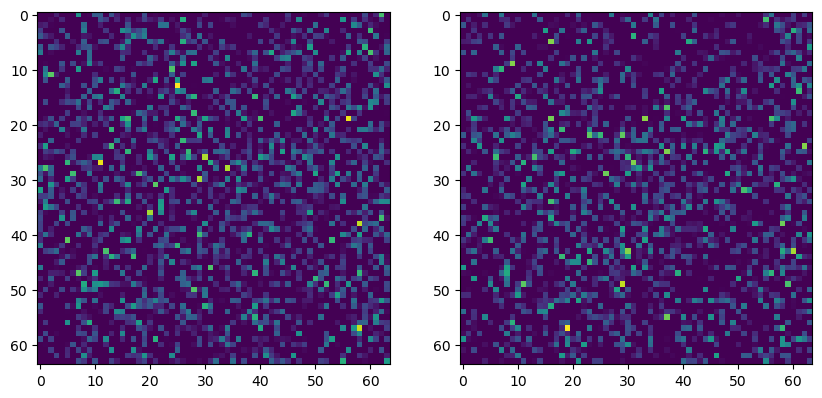

In [11]:
batch_idx, (x, y) = next(enumerate(train_loader))

x2 = x.cpu().numpy()
x2 = x2[0]

y2 = y.cpu().numpy()
y2 = y2[0]

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(x2)
plt.subplot(1,2,2)
plt.imshow(y2)

In [12]:
# Train network

model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=img_shape).cuda()

model.train() # Model set in training mode

training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=directory_path,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=model_name,val_loss_patience=30)

Epoch[1/500] Training Loss: 4.272 Reconstruction Loss: 4.204 KL Loss: 0.069
saving ./Trained_model/model/Vim_RepeatSupervisedSingleToAvg_NormHist_withAugment_last_vae.net
saving ./Trained_model/model/Vim_RepeatSupervisedSingleToAvg_NormHist_withAugment_best_vae.net
Patience: 0 Validation Loss: 4.183658599853516 Min validation loss: 4.183658599853516
Time for epoch: 263seconds
Est remaining time: 1 day, 12:27:17 or 131237 seconds
----------------------------------------
Epoch[2/500] Training Loss: 4.175 Reconstruction Loss: 4.140 KL Loss: 0.035
saving ./Trained_model/model/Vim_RepeatSupervisedSingleToAvg_NormHist_withAugment_last_vae.net
saving ./Trained_model/model/Vim_RepeatSupervisedSingleToAvg_NormHist_withAugment_best_vae.net
Patience: 0 Validation Loss: 4.170428276062012 Min validation loss: 4.170428276062012
Time for epoch: 250seconds
Est remaining time: 1 day, 10:35:00 or 124500 seconds
----------------------------------------
Epoch[3/500] Training Loss: 4.156 Reconstruction Los

KeyboardInterrupt: 

# Plotting losses

In [ ]:
directory_path = "./Trained_model/" 
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

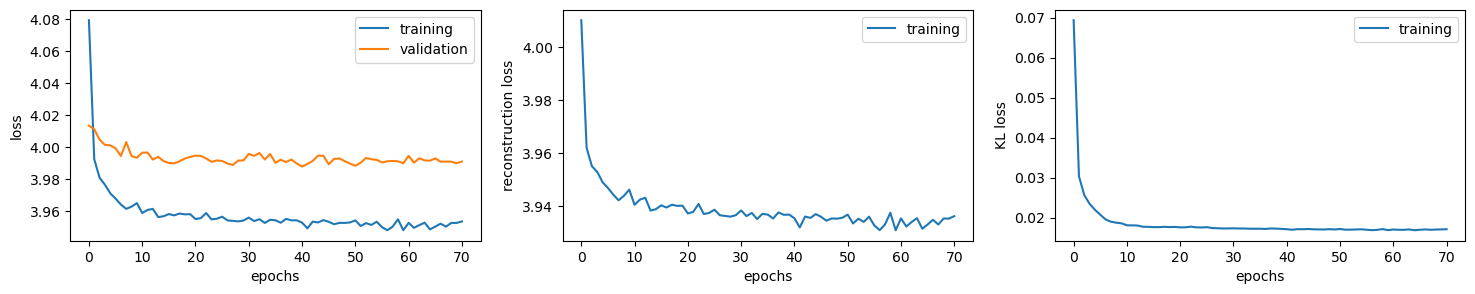

In [ ]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()